# Convert Baccmann lineage information

Here we convert the Baccman data table into a format that is compatible with the scripts developed for delta2 output files

---

## Import packages

Before starting the code we need to import all the required packages.

We use a number of important Python packages:
- [Numpy](https://numpy.org): Goto package for vector/matrix based calculations (heavily inspired by Matlab)
- [Pandas](https://pandas.pydata.org): Goto package for handling data tables (heavily inspired by R) 
- [Matplotlib](https://matplotlib.org): Goto package for plotting data
- [Seaborn](https://seaborn.pydata.org): Fancy plots made easy (Similar to ggplot in R)
- [pathlib](https://docs.python.org/3/library/pathlib.html): Path handling made easy

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
matplotlib.rc("figure", figsize=(10,5))

import seaborn as sns
import pathlib


---

## Load data

In [3]:
proj_dir = pathlib.Path(pathlib.Path.home(), 'I2ICourse', 'Project2C')
df_name = proj_dir / 'cell_data_all.csv'
df = pd.read_csv(df_name, sep=';')
df.head()

,Position,PositionIdx,Indices,Frame,Idx,Time,BacteriaLineage,NextDivisionFrame,PreviousDivisionFrame,SizeRatio,...,SizeAtBirthSpineLength,Spinelength,GrowthRateFeretMax,SizeAtBirthFeretMax,FeretMax,GrowthRateSpineWidth,SizeAtBirthSpineWidth,SpineWidth,MeanIntensityRFP,MeanIntensityGFP
0,xy00,0,0-0-0,0,0,0.0,A,4.0,NaN,NaN,...,25.2495,24.6917,0.058864,27.7199,27.0740,-0.011026,4.9342,4.6589,209.4800,1053.1000
1,xy00,0,0-0-1,0,1,0.0,B,4.0,NaN,NaN,...,25.9192,26.9725,0.053829,27.9746,29.0689,0.004870,4.2546,4.0620,189.7748,1135.8000
2,xy00,0,0-0-2,0,2,0.0,C,1.0,NaN,NaN,...,NaN,58.8917,NaN,NaN,61.0737,NaN,NaN,5.0001,200.7550,1156.4000
3,xy00,0,0-0-3,0,3,0.0,D,NaN,NaN,NaN,...,30.2778,30.2778,-0.216700,33.1361,33.1361,-0.064291,4.1022,4.1022,198.7530,997.1145
4,xy00,0,0-1-0,0,0,0.0,A,4.0,NaN,NaN,...,38.0392,39.5609,0.040383,41.7195,42.1070,-0.047089,5.3362,4.9735,316.3908,1126.3000


---

## We add additional lineage info

- `id_cell`: a unique id for each cell, from birth to division. Always use this to access cell lineages.
- `id_par`: the `id_cell` number of a cell's parent
- `id_channel`: each channel has a unique integer id
- `id_d1`: the `id_cell` number of a cell's first offspring (old-pole)
- `id_d2`: the `id_cell` number of a cell's second offspring (new-pole)
- `id_sib`: the `id_cell` number of a cell's sibling

In [145]:
def add_lin_info(df):
    ChIdx = [int(re.split("\-",ind)[1]) for ind in df['Indices']]
    df['ChannelIdx'] = ChIdx
    
    #combine PositionIdx-ChannelIdx-BacteriaLineage into single string and add string lin_id_str property
    df['lin_id_str'] = df['PositionIdx'].map(str) + '-' + df['ChannelIdx'].map(str) + '-' + df['BacteriaLineage'].map(str)
    df['chan_id_str'] = df['PositionIdx'].map(str) + '-' + df['ChannelIdx'].map(str)
    
    #convert the ID to a unique integer
    df['id_cell'] = df.groupby(['lin_id_str']).ngroup()
    df['id_channel'] = df.groupby(['chan_id_str']).ngroup()
    
    #add extra lineage info
    lut = df.groupby('lin_id_str')[['id_cell']].first()
    df = df.groupby('lin_id_str').apply(lambda x: add_lin_info_group(x, lut))
    return df
    
def add_lin_info_group(group, lut):
    name = group.name
    
    name_mom = name[:-1]
    name_d1 = name + 'H'
    name_d2 = name + 'T'
    
    group['id_par'] = lut.loc[name_mom, 'id_cell'] if name_mom in lut.index else -1
    group['id_d1'] = lut.loc[name_d1, 'id_cell'] if name_d1 in lut.index else -1
    group['id_d2'] = lut.loc[name_d2, 'id_cell'] if name_d2 in lut.index else -1
    
    if name[-1] == 'T' or name[-1] == 'H':
        name_sis = name[:-1] + 'T' if name[-1] == 'H' else name[:-1] + 'H'
        group['id_sib'] = lut.loc[name_sis, 'id_cell'] if name_sis in lut.index else -1
    else:
        group['id_sib'] = -1
    return group    

In [146]:
df = add_lin_info(df)

We can now select individual cells using `id_cell`, individual channels using `id_channel` and also easily find a cells mother or sister.

In [142]:
df.loc[(df['id_cell']==0)]

,Position,PositionIdx,Indices,Frame,Idx,Time,BacteriaLineage,NextDivisionFrame,PreviousDivisionFrame,SizeRatio,...,MeanIntensityGFP,ChannelIdx,lin_id_str,id_cell,chan_id_str,id_channel,id_par,id_d1,id_d2,id_sib
0,xy00,0,0-0-0,0,0,0.0,A,4.0,NaN,NaN,...,1053.1000,0,0-0-A,0,0-0,0,-1,1,142,-1
84,xy00,0,1-0-0,1,0,4.0,A,4.0,NaN,NaN,...,1006.2000,0,0-0-A,0,0-0,0,-1,1,142,-1
176,xy00,0,2-0-0,2,0,8.0,A,4.0,NaN,NaN,...,994.8720,0,0-0-A,0,0-0,0,-1,1,142,-1
262,xy00,0,3-0-0,3,0,12.0,A,4.0,NaN,NaN,...,987.4695,0,0-0-A,0,0-0,0,-1,1,142,-1


___

## Add growth rate and promoter activity

In [152]:
def derivative(y, frm_interval=1, log = False):
    if y.size > 2:
        y = np.log(y) if log else y
        x = np.arange(y.size) * frm_interval
        p = np.polyfit(x, y, 1) #simply 1st order polynomial fit / regression (numpy.polyfit)
        ddt = p[0] #slope of first order fit in python p[0]
    else: 
        ddt = np.nan 
    return ddt 

def calc_promoter_activity(df, channel, fit_window=5, frm_interval=1, gamma=0.0015):
    min_periods = int(np.ceil(fit_window/2))
    
    ddt_fluor = df.groupby('id_cell')[channel].rolling(fit_window, min_periods=min_periods, center=True).apply(derivative, kwargs={'frm_interval':frm_interval}).reset_index(0,drop=True)
    return (gamma + df['elongation_rate'] ) * df[channel] + ddt_fluor   

def calc_elengation_rate(df, lengthname='Spinelength', fit_window=5, frm_interval=1):
    min_periods = int(np.ceil(fit_window/2))
    return df.groupby('lin_id_str')['Spinelength'].rolling(fit_window, min_periods=min_periods, center=True).apply(derivative, kwargs={'frm_interval':frm_interval, 'log':True}).reset_index(0,drop=True)
    

In [153]:
frm_interval = 10./60 #frame interval in minutes
gamma = 0.0015 #protein degradation constant in 1/min

df['elongation_rate'] = calc_elengation_rate(df, fit_window=5, frm_interval=frm_interval)
df['promoter_act_G'] = calc_promoter_activity(df, 'MeanIntensityGFP', fit_window=5, frm_interval=frm_interval, gamma=gamma)
df['promoter_act_R'] = calc_promoter_activity(df, 'MeanIntensityRFP', fit_window=5, frm_interval=frm_interval, gamma=gamma)

In [154]:
df.describe()

,PositionIdx,Frame,Idx,Time,NextDivisionFrame,PreviousDivisionFrame,SizeRatio,TrackErrorSizeRatio,EndOfChannelContact,TruncatedDivision,...,id_channel,id_par,id_d1,id_d2,id_sib,elongation_rate,ddt_gfp,ddt_rfp,promoter_act_G,promoter_act_R
count,634091.000000,634091.000000,634091.000000,634091.000000,275216.000000,616934.000000,0.0,0.0,0.0,0.0,...,634091.000000,634091.000000,634091.000000,634091.000000,634091.000000,620557.000000,620629.000000,620629.00000,620557.000000,620557.000000
mean,19.581898,105.070211,2.375564,420.280843,106.663116,81.055836,NaN,NaN,NaN,NaN,...,309.693030,31789.609367,14114.004769,14126.962960,31719.933814,0.149732,-25.875746,12.84059,193.375329,58.871780
std,8.590790,58.672016,1.872474,234.688063,59.673282,56.679242,NaN,NaN,NaN,NaN,...,176.991915,18944.647085,20318.867115,20329.111732,19015.131836,0.682393,195.651062,104.20701,950.884059,316.984905
min,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,...,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-8.921359,-4767.245400,-4641.48228,-15809.675704,-7670.980165
25%,12.000000,57.000000,1.000000,228.000000,54.000000,32.000000,NaN,NaN,NaN,NaN,...,160.000000,15534.000000,-1.000000,-1.000000,15305.000000,-0.010919,-122.575080,-10.66800,-39.646791,-3.131161
50%,20.000000,105.000000,2.000000,420.000000,112.000000,73.000000,NaN,NaN,NaN,NaN,...,307.000000,32283.000000,-1.000000,-1.000000,32207.000000,0.161956,-16.695060,0.13506,214.104198,28.137029
75%,27.000000,151.000000,4.000000,604.000000,156.000000,118.000000,NaN,NaN,NaN,NaN,...,459.000000,47918.000000,27614.000000,27635.000000,47920.000000,0.581292,66.900000,12.99810,709.858906,127.657597
max,33.000000,216.000000,9.000000,864.000000,216.000000,216.000000,NaN,NaN,NaN,NaN,...,624.000000,65060.000000,65061.000000,65063.000000,65063.000000,9.357304,2973.900000,2399.01570,14221.284403,6189.733315


## Plot Cell Properties as function of time

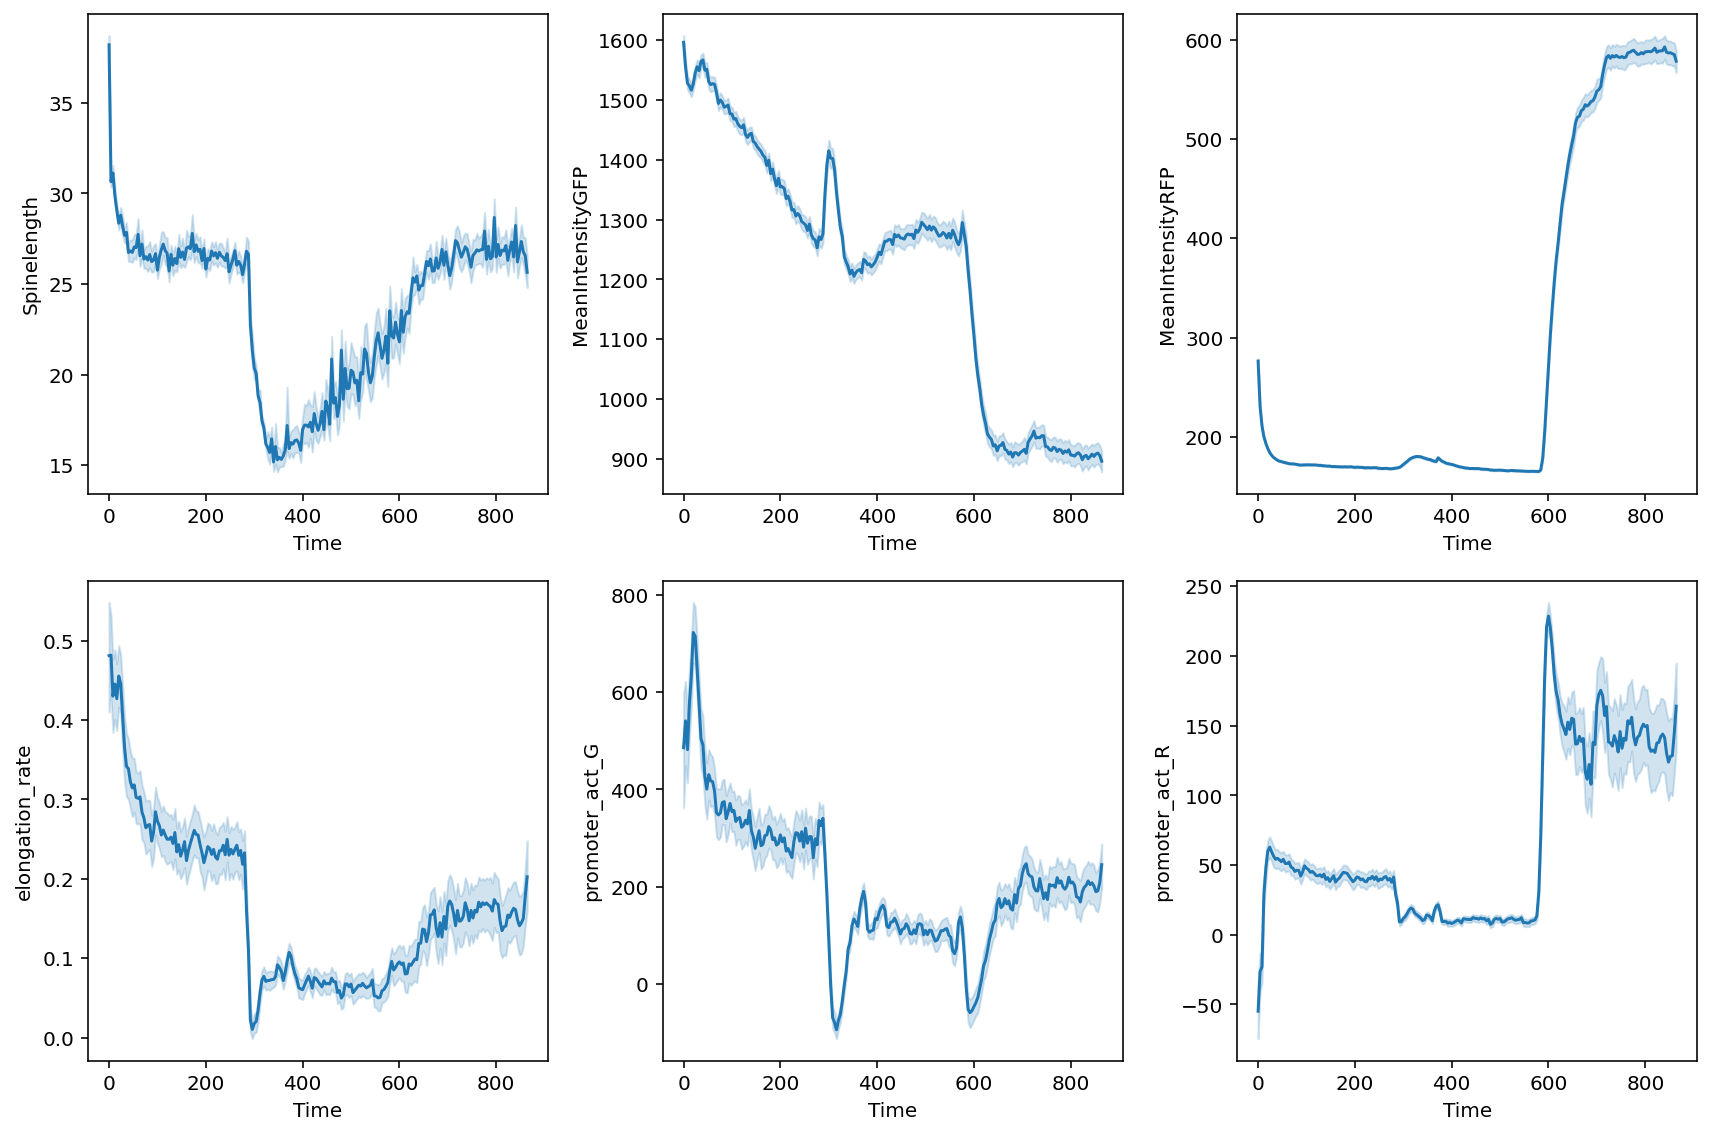

In [161]:
#extract size at birth
size_at_birth = df.groupby('id_cell').first()

fig, axs = plt.subplots(2,3, figsize=(12,8))
sns.lineplot(data=size_at_birth, x='Time', y='Spinelength', ax=axs[0,0])
sns.lineplot(data=df, x='Time', y='MeanIntensityGFP', ax=axs[0,1])
sns.lineplot(data=df, x='Time', y='MeanIntensityRFP', ax=axs[0,2])

sns.lineplot(data=df, x='Time', y='elongation_rate', ax=axs[1,0])
sns.lineplot(data=df, x='Time', y='promoter_act_G', ax=axs[1,1])
sns.lineplot(data=df, x='Time', y='promoter_act_R', ax=axs[1,2])

plt.tight_layout()

## Plot histogram of cell properties

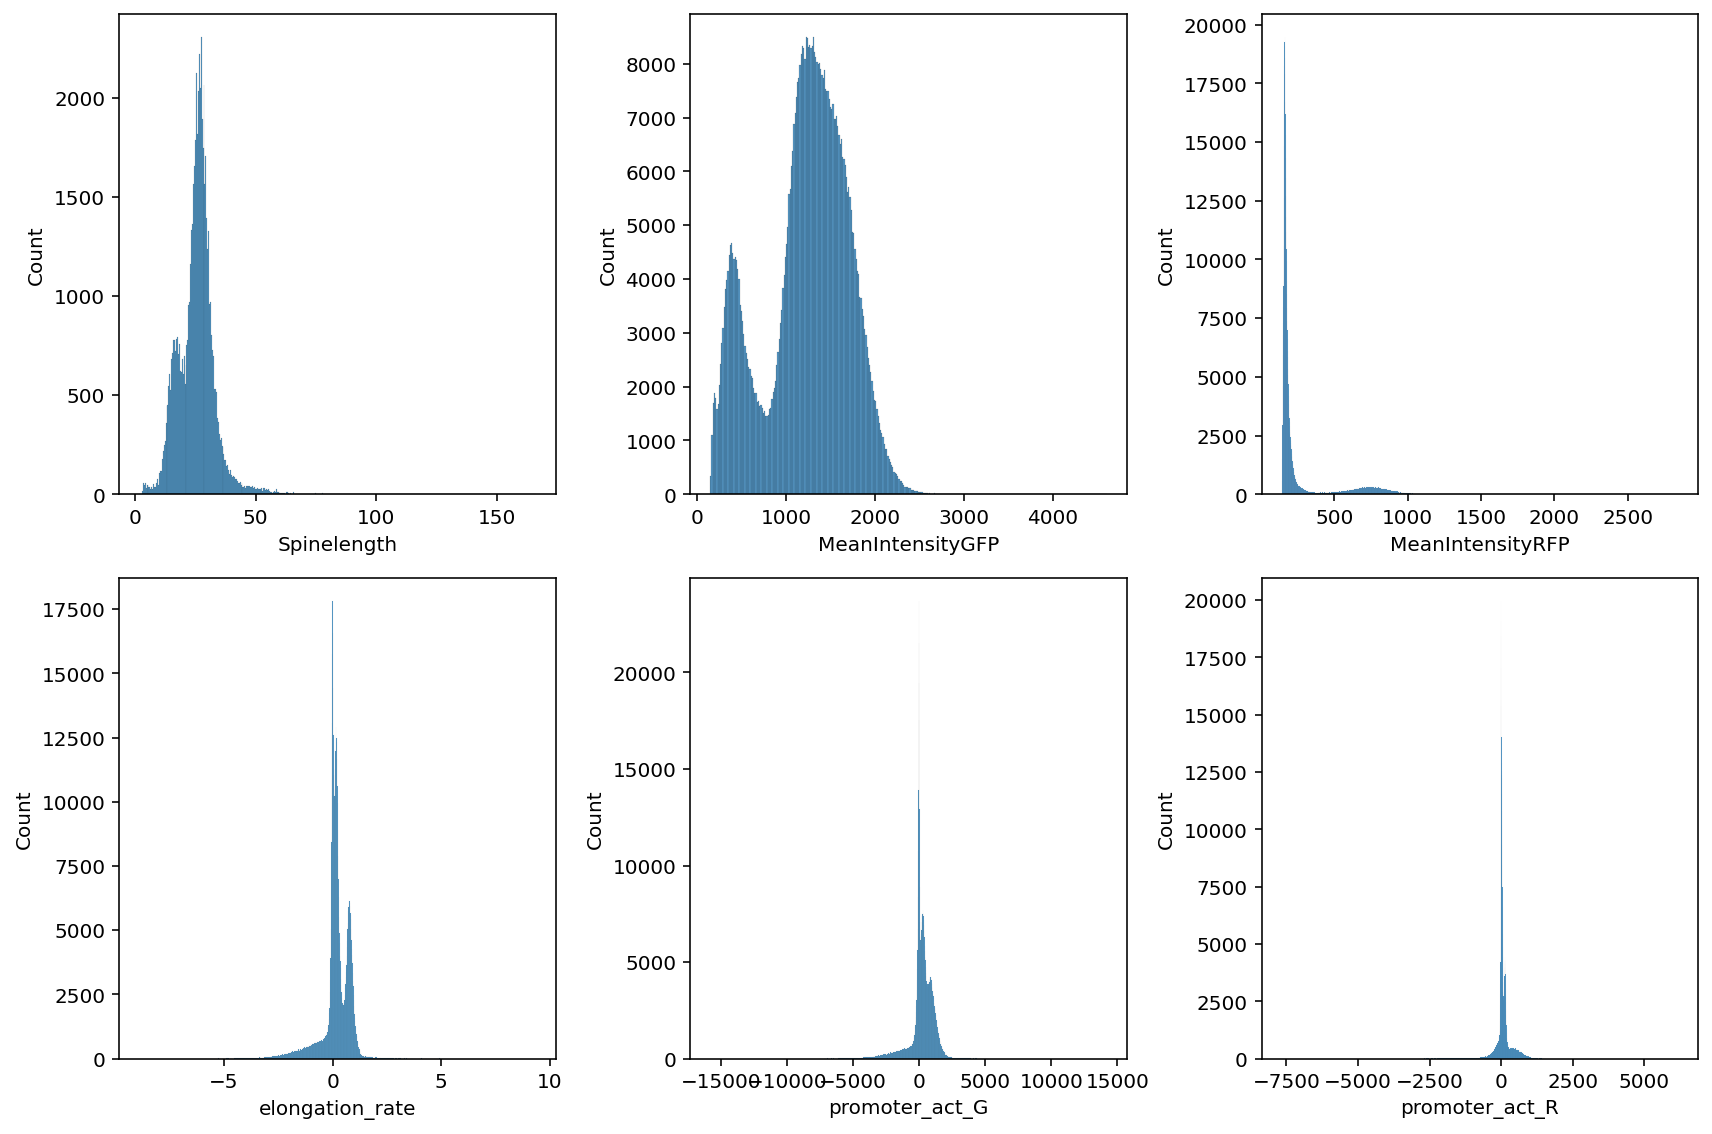

In [163]:
#extract size at birth
size_at_birth = df.groupby('id_cell').first()

fig, axs = plt.subplots(2,3, figsize=(12,8))
sns.histplot(data=size_at_birth, x='Spinelength', ax=axs[0,0])
sns.histplot(data=df, x='MeanIntensityGFP', ax=axs[0,1])
sns.histplot(data=df, x='MeanIntensityRFP', ax=axs[0,2])

sns.histplot(data=df, x='elongation_rate', ax=axs[1,0])
sns.histplot(data=df, x='promoter_act_G', ax=axs[1,1])
sns.histplot(data=df, x='promoter_act_R', ax=axs[1,2])


plt.tight_layout()

## Plot density plots

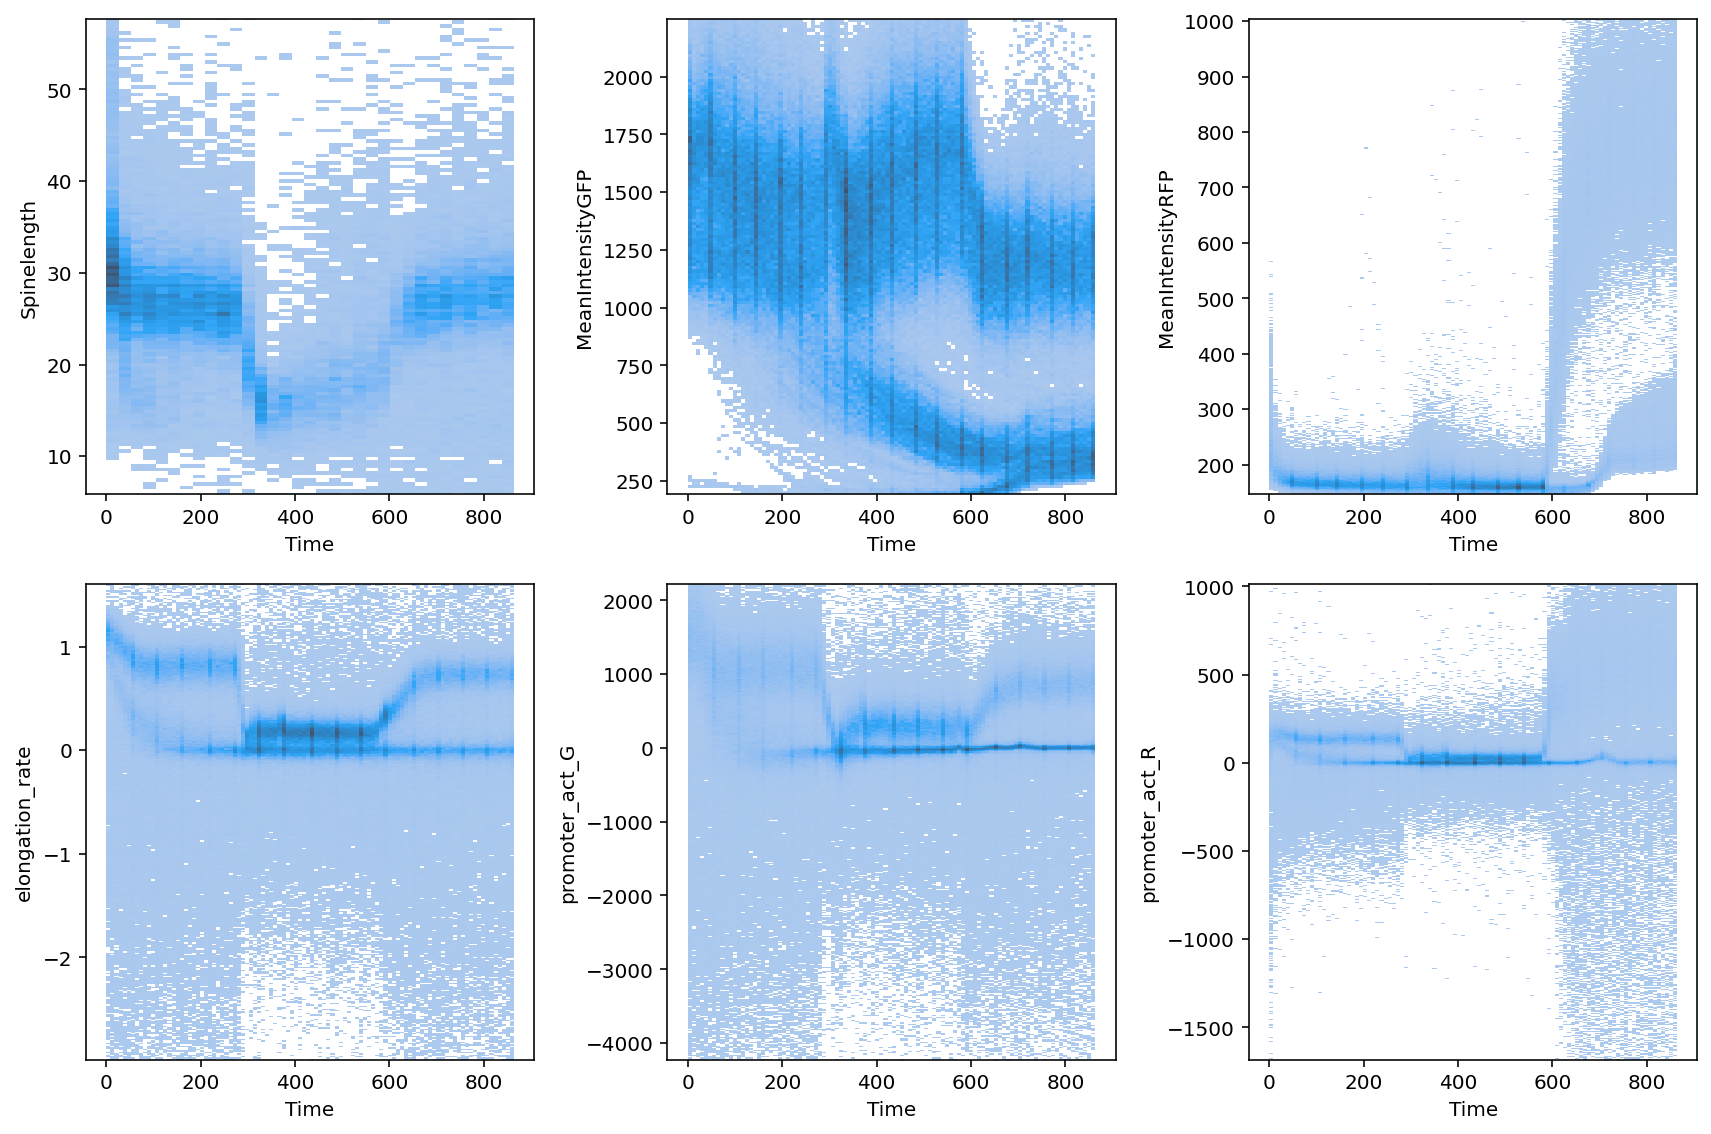

In [173]:
#extract size at birth
size_at_birth = df.groupby('id_cell').first()

fig, axs = plt.subplots(2,3, figsize=(12,8))

def plot_fun(data, var, ax, qnt = [0.005, 0.995]):
    sns.histplot(data=data, x='Time', y=var, ax=ax).set_ylim(data[var].quantile(qnt).to_numpy())
    
plot_fun(size_at_birth, 'Spinelength', axs[0,0])
plot_fun(df, 'MeanIntensityGFP', axs[0,1])
plot_fun(df, 'MeanIntensityRFP', axs[0,2])
plot_fun(df, 'elongation_rate', axs[1,0])
plot_fun(df, 'promoter_act_G', axs[1,1])
plot_fun(df, 'promoter_act_R', axs[1,2])

plt.tight_layout()

## Extract cell lineage

Code to trace a lineage back in time, this code can e.g. be used to trace back the ancestors of persister cells

In [201]:
def trace_linage(df, id_cell):
    
    curr_df = df.loc[df['id_cell']==id_cell]
    df_sub_list = []
    mom_id = id_cell
    
    while mom_id>-1:
        cur_df = df.loc[df['id_cell']==mom_id]
        df_sub_list.append(cur_df) 
        mom_id = cur_df['id_par'].iloc[0]
        
    return pd.concat(df_sub_list).set_index('Frame', drop=True).sort_index()
    

<AxesSubplot:xlabel='Time', ylabel='cumul_length'>

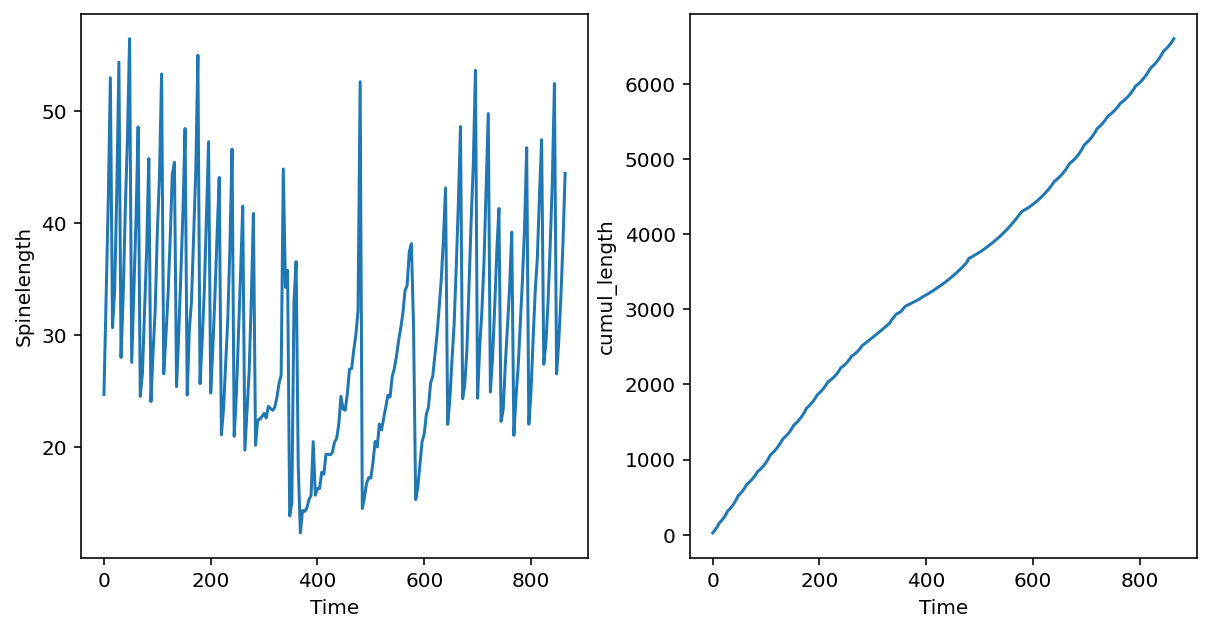

In [202]:
cell_to_trace = 29
cell_lin = trace_linage(df, cell_to_trace)

cell_lin['cumul_length'] = cell_lin['Spinelength'].cumsum()

fig, axs = plt.subplots(1,2)
sns.lineplot(data=cell_lin, x='Time', y='Spinelength', ax=axs[0])
sns.lineplot(data=cell_lin, x='Time', y='cumul_length', ax=axs[1])

In [204]:
cell_lin.head(n=20)

,Position,PositionIdx,Indices,Idx,Time,BacteriaLineage,NextDivisionFrame,PreviousDivisionFrame,SizeRatio,TrackErrorSizeRatio,...,id_par,id_d1,id_d2,id_sib,elongation_rate,ddt_gfp,ddt_rfp,promoter_act_G,promoter_act_R,cumul_length
Frame,,,,,,,,,,,,,,,,,,,,,
0,xy00,0,0-0-0,0,0.0,A,4.0,NaN,NaN,NaN,...,-1,1,142,-1,1.585876,-174.68400,-142.27200,1496.981674,190.251526,24.6917
1,xy00,0,1-0-0,0,4.0,A,4.0,NaN,NaN,NaN,...,-1,1,142,-1,1.508276,-124.93170,-94.70694,1394.204597,163.819500,58.2046
2,xy00,0,2-0-0,0,8.0,A,4.0,NaN,NaN,NaN,...,-1,1,142,-1,1.508276,-124.93170,-94.70694,1377.101858,149.961269,100.0965
3,xy00,0,3-0-0,0,12.0,A,4.0,NaN,NaN,NaN,...,-1,1,142,-1,1.374241,-56.19150,-33.93090,1302.310686,186.084052,153.0816
4,xy00,0,4-0-0,0,16.0,AH,8.0,4.0,NaN,NaN,...,0,2,137,142,0.997724,127.57140,1.89930,1116.280112,162.149905,183.7400
5,xy00,0,5-0-0,0,20.0,AH,8.0,4.0,NaN,NaN,...,0,2,137,142,1.168760,-2.63652,-2.26086,1169.729752,182.934158,217.7396
6,xy00,0,6-0-0,0,24.0,AH,8.0,4.0,NaN,NaN,...,0,2,137,142,1.168760,-2.63652,-2.26086,1205.071599,186.160448,260.4944
7,xy00,0,7-0-0,0,28.0,AH,8.0,4.0,NaN,NaN,...,0,2,137,142,1.408474,-71.56560,-0.15360,1307.311219,222.904299,314.8659
8,xy00,0,8-0-0,0,32.0,AHH,13.0,8.0,NaN,NaN,...,1,3,134,137,1.162979,-12.11010,33.41520,1043.603798,221.975564,342.8712
